## Predicción: aprendizaje supervisado sin selección de atributos

In [1]:
# Parametros de configuracion del script

dataset_name = 'prostateCancer'                         # nombre del dataset
not_genes_columns = ['group']                           # columnas que no miden valores genicos
dataset_files_folder_preprocessing ="P1_ficheros_preprocesamiento_"+dataset_name+"/" # directorio con ficheros de preprocesamiento
dataset_files_folder_comparative ="P2_ficheros_comparativaSupervisado_"+dataset_name+"/" # directorio con ficheros de comparativa con/sin seleccion de atributos
file_source_trainval = dataset_files_folder_comparative+dataset_name+'_7_trainval.csv'    # directorio con datos de train-validation
file_source_test = dataset_files_folder_comparative+dataset_name+'_7_test.csv'            # directorio con datos de test
n_splits = 3                                             # numero de particiones para validacion cruzada   
groupv0, groupv1 = 'Normal', 'Tumor'                     # poblaciones y su codificacion                     

#### Importaciones

In [2]:
# Python imports
# ----------------------------------------

# Variable export
import pickle

# Data structure
import pandas as pd
import numpy as np

# Sklearn preprocess, split, pipeline, GridSearch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import statistics

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Sklearn classification models
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import NuSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Deep learning
# import tensorflow as tf
# from tensorflow import keras

# Hacer reproducibles los experimentos en sklearn y tensorflo
SEED=42
np.random.seed(SEED)

# tf.keras.utils.set_random_seed(SEED)


In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### Lectura del dataset

In [4]:
# Division del conjunto original en un conjunto de entrenamiento-validacion y otro de test
import subprocess
subprocess.call(['python', '../split_dataset.py', 
                dataset_files_folder_preprocessing+dataset_name+'_6_diffexp.csv', 
                dataset_files_folder_comparative+dataset_name+'_7_trainval.csv',  
                dataset_files_folder_comparative+dataset_name+'_7_test.csv', 
                'group'])

0

In [5]:
dataset_trainval = pd.read_csv(file_source_trainval, sep=',', header=0, index_col=0)
Xtrainval = dataset_trainval.drop(['group'], axis=1)
ytrainval = dataset_trainval['group']
Xtrainval

,AAK1,AAMP,AANAT,AASDHPPT,AATF,AATK,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF92,ZNHIT1,ZNRD1ASP,ZNRD2,ZP2,ZPR1,ZSCAN12,ZSCAN26,ZSCAN9,ZSWIM8
67,-17.150245,39.816176,877.416912,24.822059,132.980147,1802.222059,45.801838,179.816912,5.400735,64.431618,...,-102.549265,50.452941,39.816176,12.741912,108.791912,96.073529,506.251471,168.285294,64.431618,793.502941
134,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,...,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853
12,25.135294,79.930147,76.789706,137.674265,100.394853,177.502574,33.021324,2.381495,-15.910784,67.462500,...,-97.505515,140.274265,10.325000,63.831250,11.557353,54.566912,92.991544,22.476471,29.462500,40.244118
29,39.574020,63.068382,118.509926,129.107353,103.919118,163.919118,11.243750,26.236765,-23.431250,50.740441,...,-47.862132,106.019853,11.904412,44.525000,15.952941,65.604412,123.169118,38.389706,18.432353,66.128676
9,25.267402,90.422059,75.060294,116.741176,107.738603,164.284559,118.533456,10.532230,-40.509559,34.427941,...,-44.150000,181.593382,2.542647,54.169118,19.483088,63.510294,72.112868,9.051471,22.849265,12.133088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,3.070588,5.379412,444.318382,27.744853,132.272794,839.206618,32.542279,87.457598,7.591176,79.657353,...,-85.967647,74.186765,63.672794,13.180882,39.462500,30.752206,377.258456,110.898529,43.410294,9.900735
86,64.329412,35.511029,267.215441,58.744853,161.503676,497.538235,21.019118,63.220833,18.035049,65.397794,...,-81.195588,75.772059,22.723529,6.840441,51.691176,65.397794,219.042463,32.278676,12.974265,157.344118
18,22.640931,91.280147,145.489706,89.536765,153.436765,278.596324,43.356618,26.516667,-21.569363,62.832353,...,-110.662500,257.409559,13.494853,14.434559,9.977941,77.666912,128.450368,17.613235,11.830882,-19.511765
75,106.710417,9.221324,616.604044,50.600000,134.906985,807.845588,9.819485,83.646814,7.640686,80.763235,...,-113.861029,75.400000,29.001471,42.709559,72.830147,75.400000,267.358824,77.969118,40.033824,47.842647


In [6]:
dataset_test = pd.read_csv(file_source_test, sep=',', header=0, index_col=0)
Xtest = dataset_test.drop(['group'], axis=1)
ytest = dataset_test['group']
Xtest

,AAK1,AAMP,AANAT,AASDHPPT,AATF,AATK,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF92,ZNHIT1,ZNRD1ASP,ZNRD2,ZP2,ZPR1,ZSCAN12,ZSCAN26,ZSCAN9,ZSWIM8
3,26.834314,102.680882,70.902206,122.822059,124.271691,209.405147,33.624632,-2.757353,-19.699265,50.050735,...,-78.113971,184.561029,10.538971,71.598529,11.300000,63.171324,79.866544,25.260294,22.524265,4.241544
66,-40.052451,20.680882,712.150368,38.972059,147.546691,1451.598529,24.772610,106.667647,-1.545098,36.805147,...,-71.179779,122.427941,80.491176,27.420588,63.636029,57.480147,636.013971,80.491176,45.122059,57.480147
94,28.605147,44.547059,220.144485,82.437500,132.445588,350.266912,33.988787,67.082353,7.856373,58.563971,...,-71.772059,132.445588,40.988235,44.547059,24.113971,103.919118,183.004412,48.166912,44.547059,61.877206
34,42.800000,136.252206,85.459559,89.153676,162.111765,173.457721,40.677574,18.207353,15.720588,77.567647,...,-89.412500,104.847794,12.797059,32.381618,12.797059,69.880882,126.389706,21.061029,36.284559,3.787500
35,-18.061887,69.666912,236.720588,47.278676,135.087500,434.669853,3.666912,68.781250,6.012745,62.143015,...,-115.095221,87.672059,18.852941,29.413971,32.950000,69.666912,246.505147,50.813971,43.624632,159.586029
49,29.302206,116.335294,146.143015,46.136029,108.851471,170.813971,21.067647,17.678186,27.270588,26.418382,...,-118.485294,149.632353,26.418382,80.830147,21.978676,42.901471,91.512500,31.002941,9.077206,86.794118
59,118.627941,9.254412,730.822426,48.513971,157.108088,979.868382,13.362868,119.309436,4.322794,90.768382,...,-142.858824,72.900000,70.087500,37.858824,80.925735,103.093382,434.967279,86.249265,37.858824,312.963971
119,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,...,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853,30.744853
72,57.853676,44.344118,278.596324,44.344118,136.060294,434.036029,4.149632,35.281618,8.915441,53.999265,...,-100.520588,129.450000,41.353676,50.858088,32.057353,60.297059,233.672059,57.075000,44.344118,197.331618
46,33.915196,94.455515,125.436765,83.155882,125.436765,252.023529,24.858456,36.585539,4.869853,48.941176,...,-103.420588,135.087500,14.072794,41.862500,30.221324,64.137500,101.341912,26.248529,30.221324,48.941176


#### Métricas del mejor modelo

In [7]:
pipeline_LR = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('LR', LogisticRegression(random_state=SEED, C=10, penalty='l2', solver='liblinear'))
])
pipeline_LR.fit(Xtrainval, ytrainval)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('LR',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))])

In [8]:
# Metricas de rendimiento
print("Rendimiento (accuracy) sobre entrenamiento: {:.2f}".format(
    accuracy_score(ytrainval, pipeline_LR.predict(Xtrainval))
    ))
print("Rendimiento (accuracy) sobre test: {:.2f}".format(
    accuracy_score(ytest, pipeline_LR.predict(Xtest))
    ))

print("Rendimiento (f1) sobre entrenamiento: {:.2f}".format(
    f1_score(ytrainval, pipeline_LR.predict(Xtrainval))
    ))
print("Rendimiento (f1) sobre test: {:.2f}".format(
    f1_score(ytest, pipeline_LR.predict(Xtest))
    ))

Rendimiento (accuracy) sobre entrenamiento: 0.94
Rendimiento (accuracy) sobre test: 0.90
Rendimiento (f1) sobre entrenamiento: 0.95
Rendimiento (f1) sobre test: 0.92


In [9]:
# Informe con todas las metricas

print("Informe de clasificación sobre entrenamiento")
print(classification_report(
    ytrainval, pipeline_LR.predict(Xtrainval),
    target_names=[groupv0, groupv1]
))

print("Informe de clasificación sobre test")
print(classification_report(
    ytest, pipeline_LR.predict(Xtest),
    target_names=[groupv0, groupv1]
))

Informe de clasificación sobre entrenamiento
              precision    recall  f1-score   support

      Normal       1.00      0.86      0.92        50
       Tumor       0.90      1.00      0.95        65

    accuracy                           0.94       115
   macro avg       0.95      0.93      0.94       115
weighted avg       0.95      0.94      0.94       115

Informe de clasificación sobre test
              precision    recall  f1-score   support

      Normal       1.00      0.78      0.88         9
       Tumor       0.86      1.00      0.92        12

    accuracy                           0.90        21
   macro avg       0.93      0.89      0.90        21
weighted avg       0.92      0.90      0.90        21



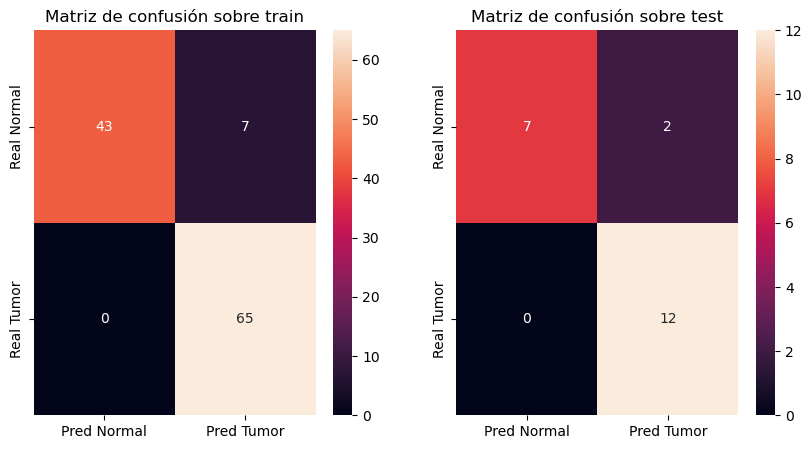

In [10]:
# Matriz de confusion
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

confussionmatrix_train = pd.DataFrame(
    confusion_matrix(ytrainval, pipeline_LR.predict(Xtrainval)), 
    columns=['Pred '+groupv0,'Pred '+groupv1], 
    index=['Real '+groupv0,'Real '+groupv1]
)
sns.heatmap(confussionmatrix_train,annot=True,fmt='d', ax=axs[0])
axs[0].set_title('Matriz de confusión sobre train')

confussionmatrix_test = pd.DataFrame(
    confusion_matrix(ytest, pipeline_LR.predict(Xtest)), 
    columns=['Pred '+groupv0,'Pred '+groupv1], 
    index=['Real '+groupv0,'Real '+groupv1]
)
sns.heatmap(confussionmatrix_test,annot=True,fmt='d', ax=axs[1])
axs[1].set_title('Matriz de confusión sobre test')

plt.show()

In [11]:
# Almacenar el modelo
with open(dataset_files_folder_comparative+dataset_name+'_8_model'+'.pkl', 'wb') as f:
    pickle.dump(pipeline_LR, f)

In [12]:
# Curva roc y auc
ytest_pred_proba = pipeline_LR.predict_proba(Xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest,  ytest_pred_proba)
auc = roc_auc_score(ytest, ytest_pred_proba)

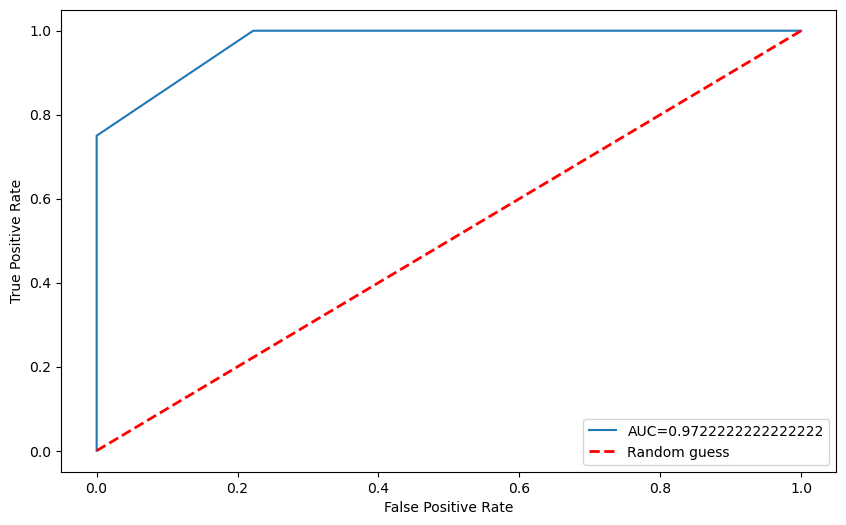

In [28]:
# Set the width of the figure (e.g., 10 inches) and the height (e.g., 6 inches)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.show()

In [23]:
mpl.rcParams['axes.linewidth'] = original_linewidth